# Sparse Data and Null Handling

## Overview

This notebook provides an overview of applying Howso Engine to sparse data (i.e., data that contain missing values) and helps to characterize how prediction performance is affected as model sparsity increases.  Howso Engine does not require any preprocessing to handle nulls or NaNs, but has notable robustness when it comes to working with data that contain them.

We demonstrate that the Howso Engine can maintain accuracy even when the training data has increasing proportions of missing values. This makes the Howso Engine a great option for use-cases with sparse datasets. Additionally, the Howso Engine has the ability to treat missing values semantically. This unlocks the ability for the Engine to find trends in the data relating to missing values for each feature, which could reveal powerful insights for users.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmlb

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

## Step 1: Load Data

We use the ``breast_w`` dataset from the [PMLB](https://github.com/EpistasisLab/pmlb).

In [2]:
df = pmlb.fetch_data("breast_w", local_cache_dir="../../data/breast_w")

df

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,target
0,5.0,1.0,1.0,1.0,2.0,0,3.0,1.0,1.0,0
1,5.0,4.0,4.0,5.0,7.0,1,3.0,2.0,1.0,0
2,3.0,1.0,1.0,1.0,2.0,2,3.0,1.0,1.0,0
3,6.0,8.0,8.0,1.0,3.0,4,3.0,7.0,1.0,0
4,4.0,1.0,1.0,3.0,2.0,0,3.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2,1.0,1.0,1.0,0
695,2.0,1.0,1.0,1.0,2.0,0,1.0,1.0,1.0,0
696,5.0,10.0,10.0,3.0,7.0,3,8.0,10.0,2.0,1
697,4.0,8.0,6.0,4.0,3.0,4,10.0,6.0,1.0,1


Since the datasets in the PMLB have been cleaned, they don't contain many missing values. We add nulls into 20% of the dataset here.

In [3]:
null_percent = 0.2
rng = np.random.default_rng()

def insert_percent_nulls(data: pd.DataFrame, percent: float) -> pd.DataFrame:
    data = data.copy(deep=True)
    mask = rng.uniform(size=data.shape) < percent
    data[mask] = None

    return data

null_df = insert_percent_nulls(df, null_percent)
null_df

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,target
0,5.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,0.0
1,5.0,NaN,4.0,5.0,7.0,NaN,3.0,2.0,1.0,0.0
2,3.0,NaN,1.0,1.0,2.0,NaN,NaN,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,NaN,7.0,1.0,NaN
4,4.0,1.0,NaN,3.0,NaN,0.0,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0
695,2.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,NaN
696,5.0,NaN,NaN,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,8.0,6.0,NaN,3.0,NaN,10.0,6.0,NaN,NaN


## Step 2: Define the Feature Attributes

The Howso Engine always requires a set of defined feature attributes. We recommend using `infer_feature_attributes` as do most of the work quickly, but we always recommend manual inspection of these resulting feature attributes.

In [4]:
features = infer_feature_attributes(null_df)
features.to_dataframe()

type decimal_places bounds                   \
                                                    min   max allow_null   
Clump_Thickness        continuous            0.0    1.0  16.0       True   
Cell_Size_Uniformity   continuous            0.0    1.0  16.0       True   
Cell_Shape_Uniformity  continuous            0.0    1.0  16.0       True   
Marginal_Adhesion      continuous            0.0    1.0  16.0       True   
Single_Epi_Cell_Size   continuous            0.0    0.0  16.0       True   
Bare_Nuclei            continuous            0.0    0.0  16.0       True   
Bland_Chromatin        continuous            0.0    0.0  16.0       True   
Normal_Nucleoli        continuous            0.0    1.0  16.0       True   
Mitoses                continuous            0.0    1.0  16.0       True   
target                    nominal            NaN    NaN   NaN       True   

                                                data_type original_type       
                      observed_min observed_max               data_type size  
Clump_Thickness                1.0         10.0    number       numeric    8  
Cell_Size_Uniformity           1.0         10.0    number       numeric    8  
Cell_Shape_Uniformity          1.0         10.0    number       numeric    8  
Marginal_Adhesion              1.0         10.0    number       numeric    8  
Single_Epi_Cell_Size           1.0         10.0    number       numeric    8  
Bare_Nuclei                    0.0         10.0    number       numeric    8  
Bland_Chromatin                1.0         10.0    number       numeric    8  
Normal_Nucleoli                1.0         10.0    number       numeric    8  
Mitoses                        1.0         10.0    number       numeric    8  
target                         NaN          NaN    number       numeric    8

## Step 3: Train and Analyze Data

We then train the data into a `Trainee` and analyze the data to determine the best hyperparameters.  Note that we are explicitly declaring our default context and action features.

In [5]:
action_features = ["target"]
context_features = features.get_names(without=action_features)

t = Trainee(features=features)
t.train(null_df)
t.analyze(context_features=context_features, action_features=action_features)

## Step 4: Measure Trainee Accuracy

Finally, we get the prediction stats.  The default action feature, `target`, is categorical so we are concerned with *precision*,  *recall*, and *accuracy*.

Here, we specifically compute `residuals_robust`. This computes what we call "Robust Residuals" which is to compute the mean absolute error of predictions on every feature where the context features are sampled over the power set of all other features. These residuals should typically be larger than the more typical "Full Residuals" which are computed as the mean absolute error of predictions on each feature where **every** other feature is used as a context.

In [6]:
accuracy = t.get_prediction_stats(
    action_feature=action_features[0],
    details = {
        "prediction_stats": True,
        "selected_prediction_stats": ["accuracy", "precision", "recall"]
        }
)[action_features[0]]

accuracy

recall       0.952514
accuracy     0.962162
precision    0.959681
Name: target, dtype: float64

In [7]:
t.delete()

## Step 5: Evaluate Performance at Multiple Sparsity Levels

Now we evaluate the `Trainee` performance at multiple sparsity levels to characterize how prediction performance holds up in the presence of many nulls.

To do this, we simply create versions of the dataset with different proportions of null values, and do the same accuracy evaluation we demonstrated above.

In [8]:
null_percentages = np.linspace(0, 0.9, num=10)
prediction_stats_list = []

for null_percent in null_percentages:
    print(f"Evaluating Trainee for {round(null_percent * 100)}% nulls")

    # Create a DataFrame that is a copy of the input DataFrame that has the correct percentage of null values.
    null_df = insert_percent_nulls(df, null_percent)
    # Infer feature attrbiutes for the new DataFrame
    null_features = infer_feature_attributes(null_df)
    # Create the Trainee, train, and analyze
    t = Trainee(features=null_features)
    t.train(null_df)
    t.analyze(context_features=context_features, action_features=action_features)
    # Compute, fetch, and store the prediction stats
    prediction_stats = t.get_prediction_stats(
        action_feature=action_features[0],
        details = {
            "prediction_stats": True,
            "selected_prediction_stats": ["accuracy", "precision", "recall"]
            }
    )[action_features[0]]

    prediction_stats_list.append(prediction_stats.T)
    # Clean up the Trainee
    t.delete()

Evaluating Trainee for 0% nulls


Evaluating Trainee for 10% nulls


Evaluating Trainee for 20% nulls


Evaluating Trainee for 30% nulls


Evaluating Trainee for 40% nulls


Evaluating Trainee for 50% nulls


/home/runner/.local/lib/python3.9/site-packages/howso/direct/client.py:376: HowsoWarning: There are no cached hyperparameters in this trainee. This operation was executed using a set of predefined default hyperparameters. Please run analyze() with your desired parameters.
  warnings.warn(w, category=HowsoWarning)


Evaluating Trainee for 60% nulls


/home/runner/.local/lib/python3.9/site-packages/howso/direct/client.py:376: HowsoWarning: There are no cached hyperparameters in this trainee. This operation was executed using a set of predefined default hyperparameters. Please run analyze() with your desired parameters.
  warnings.warn(w, category=HowsoWarning)


Evaluating Trainee for 70% nulls


/home/runner/.local/lib/python3.9/site-packages/howso/direct/client.py:376: HowsoWarning: There are no cached hyperparameters in this trainee. This operation was executed using a set of predefined default hyperparameters. Please run analyze() with your desired parameters.
  warnings.warn(w, category=HowsoWarning)


Evaluating Trainee for 80% nulls


/home/runner/.local/lib/python3.9/site-packages/howso/direct/client.py:376: HowsoWarning: There are no cached hyperparameters in this trainee. This operation was executed using a set of predefined default hyperparameters. Please run analyze() with your desired parameters.
  warnings.warn(w, category=HowsoWarning)


Evaluating Trainee for 90% nulls


/home/runner/.local/lib/python3.9/site-packages/howso/direct/client.py:376: HowsoWarning: There are no cached hyperparameters in this trainee. This operation was executed using a set of predefined default hyperparameters. Please run analyze() with your desired parameters.
  warnings.warn(w, category=HowsoWarning)


In [9]:
prediction_stats_df2 = pd.concat(prediction_stats_list, ignore_index=True)
prediction_stats_df2

0     0.964014
1     0.970193
2     0.969957
3     0.954690
4     0.958398
5     0.953760
6     0.937827
7     0.946918
8     0.945086
9     0.965970
10    0.969450
11    0.967190
12    0.936242
13    0.938690
14    0.942731
15    0.932801
16    0.951705
17    0.957351
18    0.936572
19    0.921956
20    0.936027
21    0.938776
22    0.930960
23    0.922430
24    0.855466
25    0.818129
26    0.853333
27    0.628571
28    0.455373
29    0.476190
Name: target, dtype: float64

In [10]:
type(prediction_stats_list[0])

pandas.core.series.Series

In [11]:
null_percentages

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [12]:
prediction_stats_df = pd.concat(prediction_stats_list, ignore_index=True, axis=1).T
prediction_stats_df

,precision,recall,accuracy
0,0.964014,0.970193,0.969957
1,0.953760,0.954690,0.958398
2,0.945086,0.937827,0.946918
3,0.967190,0.965970,0.969450
4,0.936242,0.938690,0.942731
5,0.957351,0.932801,0.951705
6,0.936572,0.921956,0.936027
7,0.930960,0.922430,0.938776
8,0.855466,0.818129,0.853333
9,0.455373,0.476190,0.628571


In [13]:
prediction_stats_df = pd.concat(prediction_stats_list, axis=1, ignore_index=True).T.set_index(pd.Index(null_percentages, name="Null %"), drop=True)

prediction_stats_df

,precision,recall,accuracy
Null %,,,
0.0,0.964014,0.970193,0.969957
0.1,0.953760,0.954690,0.958398
0.2,0.945086,0.937827,0.946918
0.3,0.967190,0.965970,0.969450
0.4,0.936242,0.938690,0.942731
0.5,0.957351,0.932801,0.951705
0.6,0.936572,0.921956,0.936027
0.7,0.930960,0.922430,0.938776
0.8,0.855466,0.818129,0.853333


As we can see, Howso Engine performs quite well even when significant fractions of the dataset are replaced with null values.

Text(0.5, 1.0, 'Prediction Stats for Different Levels of Sparsity')

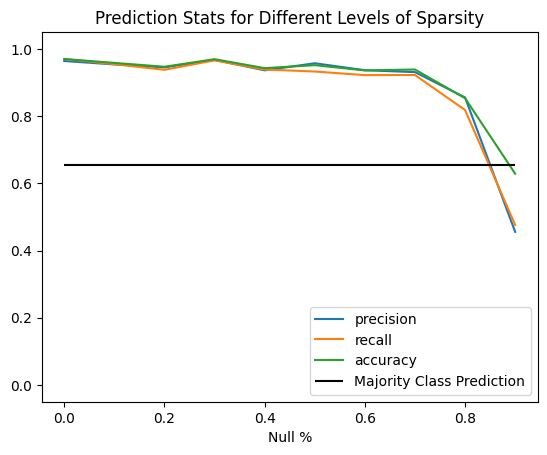

In [14]:
majority_class_accuracy = df.target.value_counts(normalize=True).max()

ax = prediction_stats_df.plot()
ax.set_ylim(-0.05, 1.05)
ax.hlines(y=majority_class_accuracy, xmin=0, xmax=0.9, color="black", label="Majority Class Prediction")
ax.legend(loc="lower right")
ax.set_title("Prediction Stats for Different Levels of Sparsity")

# Conclusion

In this notebook we demonstrate the ability of the Howso Engine to natively handle data with missing values. Furthermore we demonstrate that the Howso Engine can maintain accuracy even when the training data has increasing proportions of missing values. This makes the Howso Engine a great tool to use in use-cases where datasets have many missing values (even when the missing values themselves are informative!).